In [ ]:
import sys
# !{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

stop_words.extend(['make', 'want', 'seem', 'run', 'need', 'even', 'not', 'would', 'say', 'could', '_', 
                'be', 'know', 'go', 'get', 'do','get','far','also','way','app','usd','eur','jai','hind','jai_hind',
'done', 'try', 'many','from', 'subject', 're', 'edu','some', 'nice', 'thank','singh','mast','untuk','apne','nise','vgood',
'think', 'see', 'rather', 'lot', 'line', 'even', 'also', 'may', 'use','goog','nce','aap','thik','hai','setu','aarogya_setu','aarogya',
'take', 'come','recommend','recommended','paypal','paytm', 'let','ad','add','alcool'])

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

In [ ]:
# Import Dataset
df = pd.read_csv('dataset.csv',encoding='latin1')

In [ ]:
df.head()

,Review,Shopping Center
0,On Friday morning I was there as usual eating ...,North Cape Mall
1,"Won't call it the ""Mall of Choice"" in Kimberle...",North Cape Mall
2,I loved going to North Cape Mall because every...,North Cape Mall
3,Ideal for family outings with lots of restaura...,North Cape Mall
4,This mall I find very safe for people doing sh...,North Cape Mall


In [ ]:
df['Review']=df['Review'].apply(str)
df.head()

,Review,Shopping Center
0,On Friday morning I was there as usual eating ...,North Cape Mall
1,"Won't call it the ""Mall of Choice"" in Kimberle...",North Cape Mall
2,I loved going to North Cape Mall because every...,North Cape Mall
3,Ideal for family outings with lots of restaura...,North Cape Mall
4,This mall I find very safe for people doing sh...,North Cape Mall


In [ ]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = re.sub('[^a-zA-Z0-9]',' ',sent) # remove non english words
        sent = re.sub('\s+',' ',sent) # remove non english words
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = df.Review.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])
# [['from', 'irwin', 'arnstein', 'subject', 're', 'recommendation', 'on', 'duc', 'summary', 'whats', 'it', 'worth', 'distribution', 'usa', 'expires', 'sat', 'may', 'gmt', ...trucated...]]

[['on', 'friday', 'morning', 'was', 'there', 'as', 'usual', 'eating', 'breakfast', 'after', 'leaving', 'the', 'mall', 'to', 'another', 'centre', 'realised', 'on', 'getting', 'out', 'of', 'my', 'car', 'that', 'my', 'driver', 'door', 'was', 'damaged', 'as', 'rudely', 'of', 'another', 'car', 'banging', 'their', 'door', 'contacted', 'the', 'mall', 'for', 'video', 'footage', 'they', 'could', 'not', 'assist', 'me', 'at', 'all', 'they', 'sent', 'me', 'to', 'macdonalds', 'john', 'dory', 'even', 'roco', 'mamma', 'there', 'are', 'no', 'cameras', 'in', 'between', 'the', 'cars', 'in', 'the', 'parking', 'lot', 'they', 'have', 'an', 'arial', 'view', 'of', 'the', 'cars', 'their', 'cameras', 'can', 'see', 'number', 'plates', 'so', 'am', 'left', 'with', 'nothing', 'very', 'very', 'disappointed', 'in', 'the', 'mall', 'security', 'behold', 'if', 'something', 'happens', 'to', 'your', 'child', 'when', 'they', 'are', 'caught', 'in', 'between', 'cars', 'the', 'cameras', 'can', 'see', 'anything']]


In [ ]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=1, step=2):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=lda_model, texts=data_ready, dictionary=id2word, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

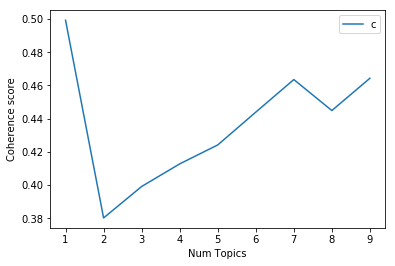

In [ ]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_ready, start=1, limit=10, step=1)
# Show graph
import matplotlib.pyplot as plt
limit=10; start=1; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=6, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)
                                           

pprint(lda_model.print_topics())

[(0,
  '0.106*"place" + 0.061*"parking" + 0.060*"friendly" + 0.033*"shop" + '
  '0.033*"good" + 0.028*"staff" + 0.025*"people" + 0.021*"easy" + '
  '0.021*"small" + 0.019*"security"'),
 (1,
  '0.060*"store" + 0.050*"shop" + 0.035*"checker" + 0.031*"service" + '
  '0.030*"mall" + 0.026*"great" + 0.020*"bank" + 0.019*"helpful" + '
  '0.015*"grocery" + 0.015*"enough"'),
 (2,
  '0.119*"shopping" + 0.096*"complain" + 0.065*"good" + 0.045*"place" + '
  '0.043*"shop" + 0.042*"clean" + 0.039*"great" + 0.036*"experience" + '
  '0.030*"safe" + 0.028*"convenient"'),
 (3,
  '0.181*"cause" + 0.031*"click" + 0.029*"space" + 0.021*"security" + '
  '0.017*"quick" + 0.016*"secure" + 0.013*"hour" + 0.013*"work" + '
  '0.012*"environment" + 0.011*"open"'),
 (4,
  '0.069*"shop" + 0.052*"mall" + 0.049*"always" + 0.032*"busy" + '
  '0.027*"parking" + 0.020*"look" + 0.019*"find" + 0.018*"love" + 0.016*"well" '
  '+ 0.015*"price"'),
 (5,
  '0.039*"center" + 0.024*"customer" + 0.022*"bad" + 0.021*"day" + '
  '

In [ ]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

C:\Users\SF-Verkijika\AppData\Roaming\Python\Python36\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.237498 -0.109315       1        1  23.265760
1     -0.048887  0.195997       2        1  20.873655
4      0.020740  0.152305       3        1  17.455410
0     -0.084393 -0.093052       4        1  15.530670
5      0.121199 -0.055777       5        1  12.828712
3      0.228840 -0.090159       6        1  10.045795, topic_info=     Category        Freq           Term       Total  loglift  logprob
term                                                                  
401   Default  114.000000          cause  114.000000  30.0000  30.0000
169   Default  174.000000       shopping  174.000000  29.0000  29.0000
898   Default  139.000000       complain  139.000000  28.0000  28.0000
43    Default  168.000000          place  168.000000  27.0000  27.0000
79    Default   78.000000          store   78.000000  26.0000  26.0000
106   Default  127.000000           good  127.000000  25.0000  25.0000
422   Default   59.000000       friendly   59.000000  24.0000  24.0000
95    Default   54.000000         always   54.000000  23.0000  23.0000
163   Default   53.000000     experience   53.000000  22.0000  22.0000
127   Default   90.000000          great   90.000000  21.0000  21.0000
44    Default  234.000000           shop  234.000000  20.0000  20.0000
613   Default   46.000000        checker   46.000000  19.0000  19.0000
19    Default  120.000000           mall  120.000000  18.0000  18.0000
98    Default   70.000000          clean   70.000000  17.0000  17.0000
480   Default   31.000000         center   31.000000  16.0000  16.0000
97    Default   36.000000           busy   36.000000  15.0000  15.0000
90    Default   44.000000           safe   44.000000  14.0000  14.0000
42    Default  141.000000        parking  141.000000  13.0000  13.0000
235   Default   57.000000     convenient   57.000000  12.0000  12.0000
111   Default   38.000000        variety   38.000000  11.0000  11.0000
456   Default   45.000000          staff   45.000000  10.0000  10.0000
635   Default   20.000000          click   20.000000   9.0000   9.0000
88    Default   25.000000         people   25.000000   8.0000   8.0000
198   Default   73.000000        service   73.000000   7.0000   7.0000
78    Default   19.000000          space   19.000000   6.0000   6.0000
8     Default   32.000000         centre   32.000000   5.0000   5.0000
188   Default   32.000000           time   32.000000   4.0000   4.0000
26    Default   38.000000       security   38.000000   3.0000   3.0000
290   Default   20.000000       customer   20.000000   2.0000   2.0000
61    Default   27.000000           bank   27.000000   1.0000   1.0000
...       ...         ...            ...         ...      ...      ...
454    Topic6    9.847425         secure   10.797283   2.2059  -4.1527
348    Topic6    8.192388           work    9.142215   2.1883  -4.3367
552    Topic6    8.198415           hour    9.149356   2.1883  -4.3360
386    Topic6    7.416750    environment    8.368933   2.1772  -4.4362
118    Topic6    6.933131           open    7.881399   2.1698  -4.5036
594    Topic6    6.290130          crowd    7.237260   2.1578  -4.6009
211    Topic6    5.958227           shoe    6.908744   2.1500  -4.6551
441    Topic6    5.565074          water    6.520898   2.1395  -4.7234
412    Topic6    5.508798           home    6.462986   2.1383  -4.7336
686    Topic6    5.473233            old    6.431342   2.1367  -4.7400
1119   Topic6    5.574851            pep    6.560859   2.1352  -4.7217
104    Topic6    5.195452          floor    6.143315   2.1304  -4.7921
699    Topic6    5.180156      necessary    6.129405   2.1298  -4.7951
677    Topic6    4.818420           like    5.777357   2.1165  -4.8675
674    Topic6    4.249629          smell    5.200880   2.0960  -4.9931
338    Topic6    3.816466     atmosphere    4.761960   2.0767  -5.1006
452    Topic6    3.488504           cool    4.

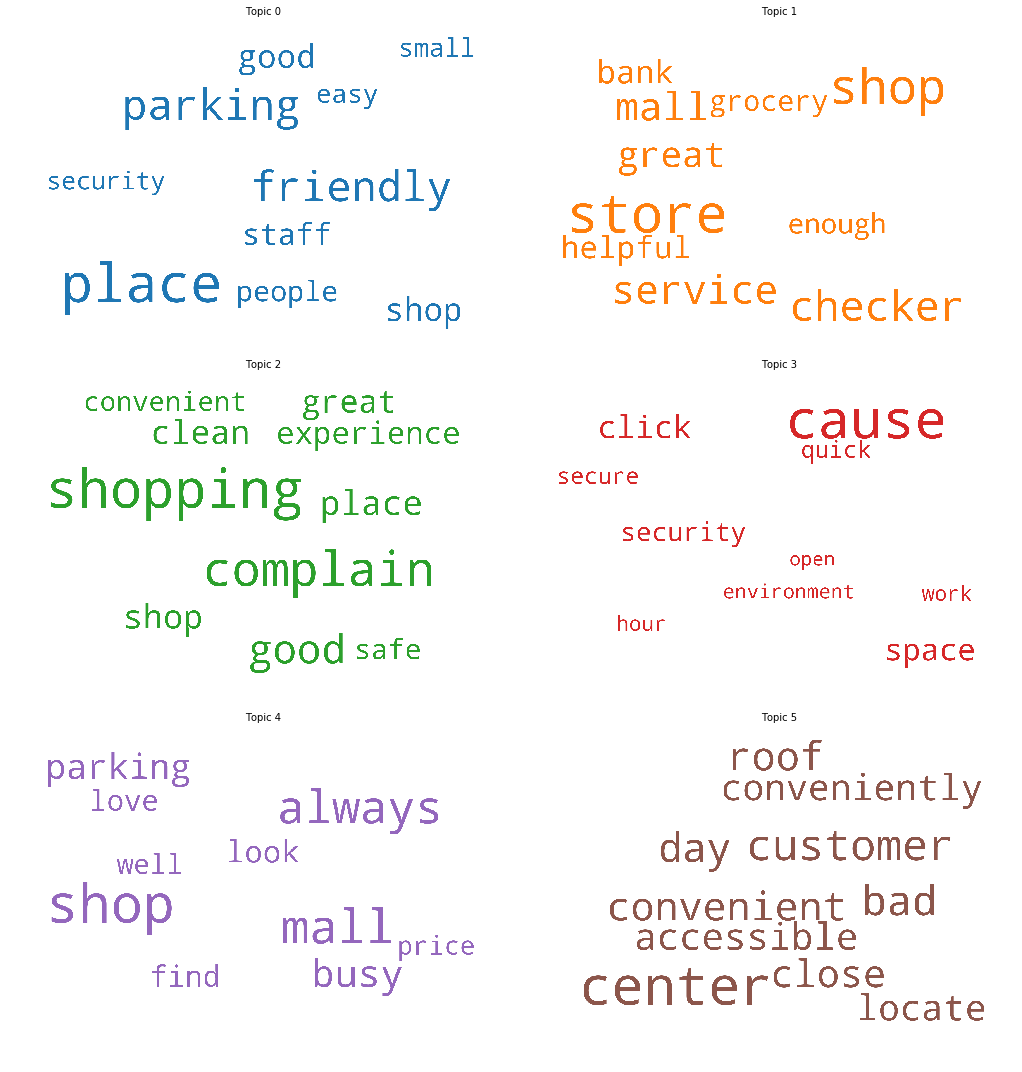

In [ ]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)



fig, axes = plt.subplots(3, 2, figsize=(15,15), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=10))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [ ]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,5.0,0.7629,"center, customer, bad, day, roof, convenient, ...","[morning, usual, eat, breakfast, leave, mall, ..."
1,1,5.0,0.7214,"center, customer, bad, day, roof, convenient, ...","[call, shop, daily, basis, locate, accessible,..."
2,2,4.0,0.8384,"shop, mall, always, busy, parking, look, find,...","[love, mall, feel, close, live, big, city, dri..."
3,3,5.0,0.3966,"center, customer, bad, day, roof, convenient, ...","[family, outing, restaurant, choose, cinema, f..."
4,4,5.0,0.6942,"center, customer, bad, day, roof, convenient, ...","[find, safe, people, shop, stress, thief, neva..."
5,5,2.0,0.5977,"shopping, complain, good, place, shop, clean, ...","[well, situated, town, easy, safe, parking, av..."
6,6,3.0,0.6995,"cause, click, space, security, quick, secure, ...","[favourite, mall, love, restaurant, route, sto..."
7,7,4.0,0.7028,"shop, mall, always, busy, parking, look, find,...","[great, stop, shop, kind, mall, likely, find, ..."
8,8,0.0,0.7578,"place, parking, friendly, shop, good, staff, p...","[never, people, still, treat, democratic, soci..."
9,9,1.0,0.7183,"store, shop, checker, service, mall, great, ba...","[easy, access, great, store, wide, variety, st..."


In [ ]:
df_dominant_topic['Reviews'] = df['Review']
df_dominant_topic['Shopping Center'] = df['Shopping Center']

In [ ]:
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,Reviews,Shopping Center
0,0,5.0,0.7629,"center, customer, bad, day, roof, convenient, ...","[morning, usual, eat, breakfast, leave, mall, ...",On Friday morning I was there as usual eating ...,North Cape Mall
1,1,5.0,0.7214,"center, customer, bad, day, roof, convenient, ...","[call, shop, daily, basis, locate, accessible,...","Won't call it the ""Mall of Choice"" in Kimberle...",North Cape Mall
2,2,4.0,0.8384,"shop, mall, always, busy, parking, look, find,...","[love, mall, feel, close, live, big, city, dri...",I loved going to North Cape Mall because every...,North Cape Mall
3,3,5.0,0.3966,"center, customer, bad, day, roof, convenient, ...","[family, outing, restaurant, choose, cinema, f...",Ideal for family outings with lots of restaura...,North Cape Mall
4,4,5.0,0.6942,"center, customer, bad, day, roof, convenient, ...","[find, safe, people, shop, stress, thief, neva...",This mall I find very safe for people doing sh...,North Cape Mall
5,5,2.0,0.5977,"shopping, complain, good, place, shop, clean, ...","[well, situated, town, easy, safe, parking, av...",Very nice mall. Well situated in town. Easy an...,North Cape Mall
6,6,3.0,0.6995,"cause, click, space, security, quick, secure, ...","[favourite, mall, love, restaurant, route, sto...",One of my three favourite malls in the Norther...,North Cape Mall
7,7,4.0,0.7028,"shop, mall, always, busy, parking, look, find,...","[great, stop, shop, kind, mall, likely, find, ...","A great one stop shop kind of mall, where you ...",North Cape Mall
8,8,0.0,0.7578,"place, parking, friendly, shop, good, staff, p...","[never, people, still, treat, democratic, soci...","Mellins, I never thought people are still bein...",North Cape Mall
9,9,1.0,0.7183,"store, shop, checker, service, mall, great, ba...","[easy, access, great, store, wide, variety, st...",Easy access great stores. Wide variety. 1 stop...,North Cape Mall


In [ ]:
df_dominant_topic.to_excel("Topics per Review.xlsx")

In [ ]:
df1 = df_dominant_topic

[Text(0,0,'Parking Availability'),
 Text(0,0,'Adequate Store Variety '),
 Text(0,0,'Positive Shopping Experience'),
 Text(0,0,'Ample Security'),
 Text(0,0,'Parking Challenges'),
 Text(0,0,'Accessibility')]

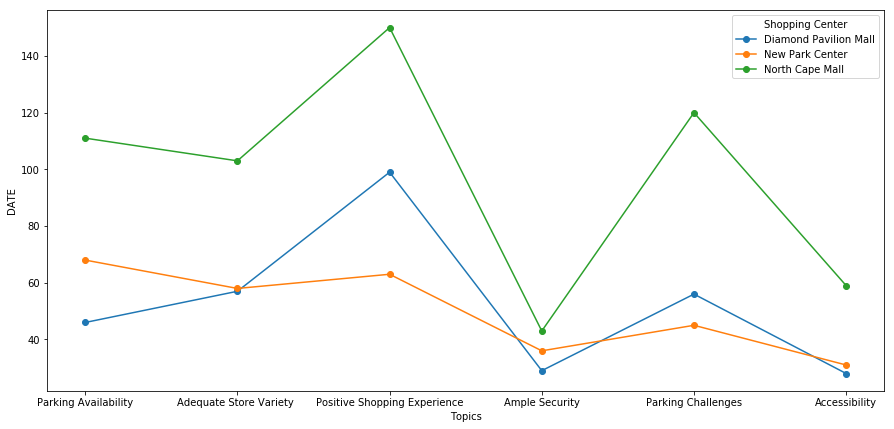

In [ ]:
# plot data
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15,7))
# use unstack()
df1.groupby(['Dominant_Topic','Shopping Center']).size().unstack().plot(ax=ax, style="-o")
ax.set_xlabel('Topics')
ax.set_ylabel('DATE')

str_month_list = ['Parking Availability','Adequate Store Variety ','Positive Shopping Experience','Ample Security','Parking Challenges','Accessibility']
ax.set_xticks(range(0,6))
ax.set_xticklabels(str_month_list)

<Figure size 1440x1440 with 0 Axes>

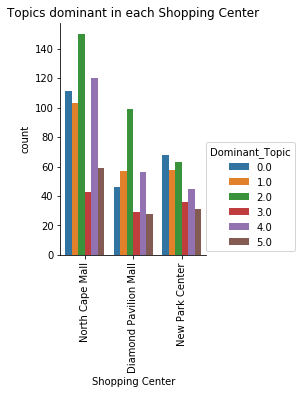

In [ ]:
import seaborn as sns
plt.figure(figsize=(20,20))
sns.factorplot(x="Shopping Center", hue="Dominant_Topic", aspect=.7,
            kind="count", data=df_dominant_topic)
plt.xticks(rotation=90)
plt.title('Topics dominant in each Shopping Center');